# GraphRAG: Graph-enhanced RAG

In many real-world scenarios, we need to extract meaningful insights from unstructured documents such as research papers, policy reports, or technical manuals. Traditional retrieval-based approaches (like vector search) may fetch relevant content but often fail to preserve the deeper semantic relationships between different parts of the document. This limits their ability to provide comprehensive, well-connected answers to complex queries.

GraphRAG (Graph-based Retrieval-Augmented Generation) is a system designed to overcome these limitations. It augments document retrieval by building a semantic knowledge graph from the documents and intelligently navigating through this graph when answering questions. This notebook presents a modular, end-to-end implementation of GraphRAG with the following goals:
- Preprocess documents into semantically meaningful chunks.
- Embed these chunks for similarity search and concept extraction.
- Build a graph of concepts and their relationships.
- Answer questions by traversing this graph.
- Visualize the reasoning path taken to arrive at the answer.

In [1]:
import networkx as nx
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.callbacks import get_openai_callback
from langchain.document_loaders import PyPDFLoader

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from typing import List, Tuple, Dict
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import spacy
import heapq

from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import numpy as np

from spacy.cli import download
from spacy.lang.en import English

# Load environment variables from a .env file
load_dotenv()

# Set the OpenAI API key environment variable
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

True

### Define the document processor class

Before we can build a knowledge graph, we need to turn raw documents into structured, meaningful components that are both small enough to process and rich enough to preserve context. This is where the `DocumentProcessor` class comes in.

The key goals here are:
- Split long documents into overlapping chunks for better context management.
- Convert those chunks into vector representations using LLM embeddings.
- Index the embeddings using FAISS so they can be quickly retrieved based on semantic similarity.
- Provide utility functions to generate embeddings in batches and compute similarity matrices, which are critical for graph construction later.

In [2]:
# Define the DocumentProcessor class
class DocumentProcessor:
    def __init__(self):
        """
        Initializes the DocumentProcessor with a text splitter and OpenAI embeddings.

        Attributes:
        - text_splitter: An instance of RecursiveCharacterTextSplitter with specified chunk size and overlap.
        - embeddings: An instance of OpenAIEmbeddings used for embedding documents.
        """
        # Initialize the chunking mechanism with configurable size and overlap
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,     # Each chunk will contain up to 1000 characters
            chunk_overlap=200    # Adjacent chunks will share 200 characters to preserve context
        )
        # Load the OpenAI embedding model for semantic vectorization
        self.embeddings = OpenAIEmbeddings()

    def process_documents(self, documents):
        """
        Processes a list of documents by splitting them into smaller chunks and creating a vector store.

        Args:
        - documents (list of str): A list of documents to be processed.

        Returns:
        - tuple: A tuple containing:
          - splits (list of str): The list of split document chunks.
          - vector_store (FAISS): A FAISS vector store created from the split document chunks and their embeddings.
        """
        # Step 1: Split documents into overlapping chunks
        splits = self.text_splitter.split_documents(documents)
        # Step 2: Compute embeddings and build the FAISS index
        vector_store = FAISS.from_documents(splits, self.embeddings)
        return splits, vector_store

    def create_embeddings_batch(self, texts, batch_size=32):
        """
        Creates embeddings for a list of texts in batches.

        Args:
        - texts (list of str): A list of texts to be embedded.
        - batch_size (int, optional): The number of texts to process in each batch. Default is 32.

        Returns:
        - numpy.ndarray: An array of embeddings for the input texts.
        """
        embeddings = []
        # Loop through the input texts in batches to avoid memory or API limits.
        for i in range(0, len(texts), batch_size):
            # Process each batch of texts
            batch = texts[i:i+batch_size]
            # Compute embeddings for the current batch
            batch_embeddings = self.embeddings.embed_documents(batch)
            # Accumulate the batch results
            embeddings.extend(batch_embeddings)
        return np.array(embeddings)

    def compute_similarity_matrix(self, embeddings):
        """
        Computes a cosine similarity matrix for a given set of embeddings.

        Args:
        - embeddings (numpy.ndarray): An array of embeddings.

        Returns:
        - numpy.ndarray: A cosine similarity matrix for the input embeddings.
        """
        return cosine_similarity(embeddings)

The `DocumentProcessor` class is responsible for taking raw documents and preparing them for use in our graph-based retrieval system.
- Document chunking: Long-form text is segmented into smaller units using overlapping windows. Overlap ensures that important concepts that span across chunk boundaries are not lost.
- Embedding: Each chunk is converted into a high-dimensional vector using the OpenAI embedding model. These vectors capture the semantic meaning of the text, enabling smarter comparisons than keyword matching.
- Vector indexing with FAISS: Chunks and their embeddings are stored in a FAISS index for fast retrieval. FAISS is particularly efficient for approximate nearest neighbor search in high-dimensional spaces — critical when querying the graph later.
- Batch embedding utility: The `create_embeddings_batch` method helps in scenarios where many texts need to be embedded without overloading memory. This is often useful during graph construction or similarity matrix computations. Although the documents are chunked, embedding them in smaller batches prevents overload on the API and keeps memory usage manageable. It performs also better in terms of speed and cost when run in batches. This becomes critical when dealing with large document sets.
- Cosine similarity matrix: This method computes a full similarity matrix between chunks. This becomes crucial when we start adding edges between graph nodes based on semantic closeness.


### Define the knowledge graph class

Once the documents are chunked and embedded, we need a way to connect and reason over them in a structured, meaningful way. This is where the knowledge graph comes in. The knowledge graph organizes document chunks into a network of nodes and edges. This part of the system builds a graph structure where:
- Nodes represent individual document chunks.
- Edges are drawn based on both how semantically similar those chunks are (how similar their meanings are), and how much conceptual meaning they share (what topics or ideas they talk about).
- Each node stores the chunk’s content and the set of extracted concepts and entities it discusses.

By structuring document chunks this way, we can navigate the document space semantically rather than linearly and traverse related ideas across large corpora using concepts rather than just keyword overlap. It enables also explainable and visual reasoning over how answers are found. What makes this system powerful is its dual-representation:
- It captures semantic proximity (via cosine similarity of embeddings), and
- It recognizes shared meaning (via extracted concepts and entities).

We also incorporate a few important enhancements:
- A lemmatizer ensures that different forms of the same word (e.g., "running" and "run") are treated as the same concept.
- A concept cache avoids redundant processing by reusing results when possible.
- Multithreading accelerates concept extraction across all document chunks to keep things scalable and efficient.

In [3]:
# Define the Pydantic model of the concepts class for structured output from LLM
class Concepts(BaseModel):
    concepts_list: List[str] = Field(description="List of concepts")

# Define the KnowledgeGraph class
class KnowledgeGraph:
    def __init__(self):
        """
        Initializes the KnowledgeGraph with a graph, lemmatizer, and NLP model.

        Attributes:
        - graph: An instance of a networkx Graph.
        - lemmatizer: An instance of WordNetLemmatizer.
        - concept_cache: A dictionary to cache extracted concepts.
        - nlp: An instance of a spaCy NLP model.
        - edges_threshold: A float value that sets the threshold for adding edges based on similarity.
        """
        self.graph = nx.Graph()  # Undirected graph to represent semantic relationships
        self.lemmatizer = WordNetLemmatizer()  # Lemmatizer to normalize extracted concepts
        self.concept_cache = {}  # Cache to prevent redundant concept extraction
        self.nlp = self._load_spacy_model()  # spaCy model for NER
        self.edges_threshold = 0.8  # Similarity threshold for edge creation

    def build_graph(self, splits, llm, embedding_model):
        """
        Builds the knowledge graph by adding nodes, creating embeddings, extracting concepts, and adding edges.

        Args:
        - splits (list): A list of document splits.
        - llm: An instance of a large language model.
        - embedding_model: An instance of an embedding model.

        Returns:
        - None
        """
        self._add_nodes(splits)  # Step 1: Add each chunk as a node
        embeddings = self._create_embeddings(splits, embedding_model)  # Step 2: Compute embeddings
        self._extract_concepts(splits, llm)  # Step 3: Extract concepts using spaCy + LLM
        self._add_edges(embeddings)  # Step 4: Add edges based on semantic similarity + shared concepts

    def _add_nodes(self, splits):
        """
        Adds nodes to the graph from the document splits. One for each text chunk.

        Args:
        - splits (list): A list of document splits.

        Returns:
        - None
        """
        for i, split in enumerate(splits):  # Loop over all document splits
            self.graph.add_node(i, content=split.page_content)  # Add node with chunk text - use index as node ID and store content

    def _create_embeddings(self, splits, embedding_model):
        """
        Creates embeddings for the document splits using the embedding model.

        Args:
        - splits (list): A list of document splits.
        - embedding_model: An instance of an embedding model.

        Returns:
        - numpy.ndarray: An array of embeddings for the document splits.
        """
        texts = [split.page_content for split in splits]  # Extract text content from splits
        return embedding_model.embed_documents(texts)  # Get embeddings from model

    def _compute_similarities(self, embeddings):
        """
        Computes the cosine similarity matrix for the embeddings.

        Args:
        - embeddings (numpy.ndarray): An array of embeddings.

        Returns:
        - numpy.ndarray: A cosine similarity matrix for the embeddings.
        """
        return cosine_similarity(embeddings)  # Return pairwise similarity matrix

    def _load_spacy_model(self):
        """
        Loads the spaCy NLP model, downloading it if necessary.

        Args:
        - None

        Returns:
        - spacy.Language: An instance of a spaCy NLP model.
        """
        try:
            return spacy.load("en_core_web_sm")  # Try loading the model locally
        except OSError:
            print("Downloading spaCy model...")  # Fallback to downloading if not found
            download("en_core_web_sm")
            return spacy.load("en_core_web_sm")  # Reload after download

    def _extract_concepts_and_entities(self, content, llm):
        """
        Extracts concepts and named entities from the content using spaCy and a large language model. Results are cached to avoid redundant processing.

        Args:
        - content (str): The content from which to extract concepts and entities.
        - llm: An instance of a large language model.

        Returns:
        - list: A list of extracted concepts and entities.
        """
        if content in self.concept_cache:  # Use cache if already processed
            return self.concept_cache[content]

        # Step 1: Use spaCy to extract named entities (PERSON, ORG, etc.)
        doc = self.nlp(content)  # Run NLP pipeline
        named_entities = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "ORG", "GPE", "WORK_OF_ART"]]

        # Step 2: Use LLM to extract abstract concepts using a prompt
        concept_extraction_prompt = PromptTemplate(
            input_variables=["text"],
            template="Extract key concepts (excluding named entities) from the following text:\n\n{text}\n\nKey concepts:"
        )
        # Create a chain: prompt → LLM → structured output
        concept_chain = concept_extraction_prompt | llm.with_structured_output(Concepts)
        general_concepts = concept_chain.invoke({"text": content}).concepts_list  # LLM response

        # Step 3: Combine named entities and general concepts
        all_concepts = list(set(named_entities + general_concepts))

        self.concept_cache[content] = all_concepts # Store result in cache
        return all_concepts

    def _extract_concepts(self, splits, llm):
        """
        Extracts concepts for all document splits using multi-threading.

        Args:
        - splits (list): A list of document splits.
        - llm: An instance of a large language model.

        Returns:
        - None
        """
        # Use a thread pool for parallel execution
        with ThreadPoolExecutor() as executor:
            # Submit all chunks to concept extractor in parallel
            future_to_node = {
                executor.submit(self._extract_concepts_and_entities, split.page_content, llm): i
                for i, split in enumerate(splits)  # Submit tasks for each split
                }

            # Wait for all tasks to complete and assign the result to the corresponding node
            for future in tqdm(as_completed(future_to_node), total=len(splits), desc="Extracting concepts and entities"):
                node = future_to_node[future]  # Get node ID
                concepts = future.result()  # Get extracted concepts
                self.graph.nodes[node]['concepts'] = concepts  # Add extracted concepts to graph node

    def _add_edges(self, embeddings):
        """
        Adds edges to the graph based on the similarity of embeddings and shared concepts.

        Args:
        - embeddings (numpy.ndarray): An array of embeddings for the document splits.

        Returns:
        - None
        """
        # Compute similarity scores
        similarity_matrix = self._compute_similarities(embeddings)
        num_nodes = len(self.graph.nodes)  # Total number of nodes

        # Iterate through all node pairs
        for node1 in tqdm(range(num_nodes), desc="Adding edges"):
            # Compare with every other node (once)
            for node2 in range(node1 + 1, num_nodes):
                # Get similarity between the two nodes
                similarity_score = similarity_matrix[node1][node2]

                # Only consider highly similar nodes
                if similarity_score > self.edges_threshold:
                    # Find intersection of their concepts
                    shared_concepts = set(self.graph.nodes[node1]['concepts']) & set(self.graph.nodes[node2]['concepts'])
                    # Calculate final edge weight using both similarity and shared concepts
                    edge_weight = self._calculate_edge_weight(node1, node2, similarity_score, shared_concepts)
                    # Add edge to the graph with metadata
                    self.graph.add_edge(node1, node2, weight=edge_weight,
                                        similarity=similarity_score,
                                        shared_concepts=list(shared_concepts))

    def _calculate_edge_weight(self, node1, node2, similarity_score, shared_concepts, alpha=0.7, beta=0.3):
        """
        Calculates the weight of an edge based on similarity score and shared concepts.

        Args:
        - node1 (int): The first node.
        - node2 (int): The second node.
        - similarity_score (float): The similarity score between the nodes.
        - shared_concepts (set): The set of shared concepts between the nodes.
        - alpha (float, optional): The weight of the similarity score. Default is 0.7.
        - beta (float, optional): The weight of the shared concepts. Default is 0.3.

        Returns:
        - float: The calculated weight of the edge.
        """
        # Find the smaller of the two concept lists (for normalization)
        max_possible_shared = min(len(self.graph.nodes[node1]['concepts']), len(self.graph.nodes[node2]['concepts']))

        # Normalize shared concept count and prevent division by zero
        normalized_shared_concepts = len(shared_concepts) / max_possible_shared if max_possible_shared > 0 else 0
        # Final edge weight - Weighted combination of similarity and concept overlap
        return alpha * similarity_score + beta * normalized_shared_concepts

    def _lemmatize_concept(self, concept):
        """
        Lemmatizes a given concept.

        Args:
        - concept (str): The concept to be lemmatized.

        Returns:
        - str: The lemmatized concept.
        """
        # Split phrase into words and lemmatize each word in the phrase
        return ' '.join([self.lemmatizer.lemmatize(word) for word in concept.lower().split()])

1. `__init__()` - This is the constructor for the `KnowledgeGraph` class — it is called when we create a new instance of the graph.
  * It initializes a blank **NetworkX graph**. This graph will store document chunks as nodes and their semantic relationships as edges.
  * A **WordNetLemmatizer** is created to normalize different grammatical forms of concepts (e.g., "running" → "run"). This helps avoid redundant or fragmented concepts.
  * A **cache dictionary** is set up to store extracted concepts for each chunk, preventing repetitive work.
  * A **spaCy NLP pipeline** is loaded to handle entity recognition. If the model isn’t available locally, it’s downloaded.
  * A **threshold** for semantic similarity is defined. Only document chunks that are *more similar than this threshold* will be connected by edges. This ensures that only strong relationships are reflected in the graph.

  This setup gives the graph the tools it needs to analyze text, identify concepts, and build relationships meaningfully and efficiently.

2. `build_graph(splits, llm, embedding_model)` - This is the main method that constructs the knowledge graph from a list of document splits (chunks of text). It follows four major steps:
  1. **Add nodes** to the graph, where each node represents a chunk of text.
  2. **Compute embeddings** for all chunks using the provided embedding model. These are needed for semantic similarity comparisons.
  3. **Extract concepts** from each chunk using a combination of spaCy and a language model.
  4. **Add edges** between semantically similar and conceptually overlapping chunks.

  This function orchestrates the full graph construction pipeline, ensuring all relevant information is embedded in the graph.

3. `_add_nodes(splits)` - This function simply adds each chunk of text as a node in the graph.
  * Each node is assigned a unique numeric ID (based on its position in the list).
  * The actual chunk content is stored as an attribute (`content`) on the node.

  This is the foundation of the graph. Without nodes, there is nothing to connect or reason over.

4. `_create_embeddings(splits, embedding_model)` - This function creates semantic vector representations for each chunk of text.
  * It extracts the text content from each split.
  * Then it sends that list of texts to the embedding model, which returns a matrix of embeddings.

  These embeddings capture the meaning of each chunk in a machine-understandable format, which is key to computing semantic similarity later.

5. `_compute_similarities(embeddings)` - This function calculates a pairwise cosine similarity matrix between all chunk embeddings.
  * The result is a 2D array where each entry `[i][j]` shows how semantically similar chunk `i` is to chunk `j`.

6. `_load_spacy_model()` - This utility function loads the `en_core_web_sm` model from spaCy.
  * This model provides NER, which allows us to extract proper names and other meaningful real-world entities from text.

7. `_extract_concepts_and_entities(content, llm)` - This is one of the most critical functions. It extracts both named entities and abstract concepts from a chunk of text. Steps:
  1. **Cache check**: If this chunk has already been processed, reuse the result.
  2. **Entity extraction with spaCy**: Named entities like people, places, organizations, and works of art are extracted using spaCy. These are often key anchors in a chunk’s meaning.
  3. **Concept extraction with LLM**: Using a prompt, a language model extracts *general concepts* from the text that are not limited to proper names. This might include abstract topics, domain-specific terms, or key ideas.
  4. **Merge and deduplicate** the two lists (entities + concepts), store in the cache, and return.

  This hybrid extraction process makes each chunk semantically rich, both in terms of concrete references and abstract meaning.

8. `_extract_concepts(splits, llm)` - This method extracts concepts from all document chunks, using multithreading for speed.
  * It uses a `ThreadPoolExecutor` to parallelize calls to `_extract_concepts_and_entities`.
  * As each chunk is processed, the list of concepts is stored as a node attribute in the graph.

  This allows concept extraction to scale to large document collections without becoming a bottleneck.

9. `_add_edges(embeddings)` - This method adds edges between nodes (document chunks) that are both:
  * Semantically similar (according to their vector embeddings), and
  * Conceptually overlapping (they share some of the same extracted concepts).

  Steps:
  1. Compute the similarity matrix.
  2. For each pair of chunks:
    * Check if their similarity exceeds the defined threshold.
    * Identify which concepts they share.
    * Compute a combined edge weight using both similarity and shared concept count.
    * Add an edge with metadata (weight, similarity, shared concepts).

  This is where the graph becomes interconnected and meaningful. Strongly related chunks get connected, allowing us to navigate the document space by following lines of shared meaning.

10. `_calculate_edge_weight(...)` - This helper function determines how "strong" a connection (edge) is between two chunks.
  * It blends two signals:
    * The semantic similarity between the embeddings.
    * The number of shared concepts (normalized by chunk size).
  * Two parameters, `alpha` and `beta`, control how much each factor contributes to the final score.

  This allows for flexible weighting — we can favor pure semantic similarity, pure concept overlap, or a mix.

11. `_lemmatize_concept(concept)` - This function lemmatizes a concept string — that is, it reduces all words in a phrase to their base forms. Lemmatization helps consolidate the graph and improves overlap detection between concept sets.


Altogether, this class builds a powerful and interpretable semantic structure over a document collection.


### Define the query engine class
Now, we build a query-answering engine that intelligently combines semantic search, context compression, and knowledge graph exploration. It is designed to simulate a thoughtful and efficient way of responding to user queries, not just by pulling up relevant content, but by deeply understanding relationships between concepts and strategically expanding context when needed.

At its core, the system is built around the `QueryEngine` class, which orchestrates how queries are processed: from retrieving the most relevant pieces of information using a vector store, to traversing a knowledge graph that interlinks concepts and content nodes. The engine uses a Dijkstra-inspired approach to traverse this graph—prioritizing strongly connected and highly relevant nodes—while continuously checking whether the current accumulated context is enough to answer the question. This mechanism avoids overloading the language model with excessive or irrelevant content and aims to deliver focused, accurate answers efficiently.

An integral part of this pipeline is the `AnswerCheck` component, which acts as a structured validation layer. After gathering context, the system queries the language model to determine whether the answer is complete or more exploration is needed. If the context is deemed insufficient, the system intelligently expands it by exploring connected nodes, bringing in fresh perspectives or missing pieces from neighboring concepts. This keeps the answer grounded in relevant data while staying aware of the user’s original intent.

The process is not only retrieval-based but also adaptive. When needed, the language model is leveraged both to compress context for relevance and to synthesize an answer from the accumulated information. The architecture ensures that content is not just pulled and pasted, but thoughtfully filtered and interpreted, using both symbolic (graph) and sub-symbolic (embedding) reasoning strategies.

When a user asks a question, the system begins by retrieving the most relevant documents based on their semantic similarity. Rather than blindly accepting these as enough, it performs a sort of "reasoning audit"—asking a language model to judge whether the information so far can fully answer the question. If not, it doesn't stop there. It kicks off a knowledge graph traversal, following the strongest connections between concepts, always checking along the way whether the accumulating knowledge is sufficient.

This mimics how a human might think through a tough problem—starting with what they know, checking if it's enough, and if not, exploring related ideas until they can form a complete answer. It's a blend of search, reasoning, and synthesis.

In [4]:
# Define the AnswerCheck class - a pydantic model that used for structured output parsing from the language model.
class AnswerCheck(BaseModel):
    is_complete: bool = Field(description="Whether the current context provides a complete answer to the query")
    answer: str = Field(description="The current answer based on the context, if any")

# Define the QueryEngine class - handles the end-to-end process of answering user queries by retrieving relevant content, expanding context through a knowledge graph, and using a language model to synthesize answers.
class QueryEngine:
    def __init__(self, vector_store, knowledge_graph, llm):
        # Store references to the vector store, knowledge graph, and language model
        self.vector_store = vector_store
        self.knowledge_graph = knowledge_graph
        self.llm = llm

        self.max_context_length = 4000  # Set the maximum token length for context (used to truncate or batch content if needed)
        self.answer_check_chain = self._create_answer_check_chain()  # Initialize the answer checking chain, which helps determine if a context sufficiently answers a query

    # Internal method to create a chain that determines if a given context is sufficient to fully answer a query
    def _create_answer_check_chain(self):
        """
        Creates a chain to check if the context provides a complete answer to the query.

        Args:
        - None

        Returns:
        - Chain: A chain to check if the context provides a complete answer.
        """
        answer_check_prompt = PromptTemplate(
            input_variables=["query", "context"],
            template="Given the query: '{query}'\n\nAnd the current context:\n{context}\n\nDoes this context provide a complete answer to the query? If yes, provide the answer. If no, state that the answer is incomplete.\n\nIs complete answer (Yes/No):\nAnswer (if complete):"
        )
        # Chain combines the prompt with the language model and expects output in AnswerCheck format
        return answer_check_prompt | self.llm.with_structured_output(AnswerCheck)

    # Checks whether the current context answers the query completely
    def _check_answer(self, query: str, context: str) -> Tuple[bool, str]:
        """
        Checks if the current context provides a complete answer to the query.

        Args:
        - query (str): The query to be answered.
        - context (str): The current context.

        Returns:
        - tuple: A tuple containing:
          - is_complete (bool): Whether the context provides a complete answer.
          - answer (str): The answer based on the context, if complete.
        """
        response = self.answer_check_chain.invoke({"query": query, "context": context})
        return response.is_complete, response.answer

    # Traverses the knowledge graph to build a rich context and extract the final answer
    def _expand_context(self, query: str, relevant_docs) -> Tuple[str, List[int], Dict[int, str], str]:
        """
        Expands the context by traversing the knowledge graph using a Dijkstra-like approach.

        This method implements a modified version of Dijkstra's algorithm to explore the knowledge graph,
        prioritizing the most relevant and strongly connected information. The algorithm works as follows:

        1. Initialize:
           - Start with nodes corresponding to the most relevant documents.
           - Use a priority queue to manage the traversal order, where priority is based on connection strength.
           - Maintain a dictionary of best known "distances" (inverse of connection strengths) to each node.

        2. Traverse:
           - Always explore the node with the highest priority (strongest connection) next.
           - For each node, check if we've found a complete answer.
           - Explore the node's neighbors, updating their priorities if a stronger connection is found.

        3. Concept Handling:
           - Track visited concepts to guide the exploration towards new, relevant information.
           - Expand to neighbors only if they introduce new concepts.

        4. Termination:
           - Stop if a complete answer is found.
           - Continue until the priority queue is empty (all reachable nodes explored).

        This approach ensures that:
        - We prioritize the most relevant and strongly connected information.
        - We explore new concepts systematically.
        - We find the most relevant answer by following the strongest connections in the knowledge graph.

        Args:
        - query (str): The query to be answered.
        - relevant_docs (List[Document]): A list of relevant documents to start the traversal.

        Returns:
        - tuple: A tuple containing:
          - expanded_context (str): The accumulated context from traversed nodes.
          - traversal_path (List[int]): The sequence of node indices visited.
          - filtered_content (Dict[int, str]): A mapping of node indices to their content.
          - final_answer (str): The final answer found, if any.
        """
        # Initialize variables
        expanded_context = ""  # Accumulates context from relevant nodes
        traversal_path = []  # Sequence of node indices visited
        visited_concepts = set()  # Tracks concepts already visited
        filtered_content = {}  # Maps node indices to their text content
        final_answer = ""  # Stores the final answer (if found early)

        priority_queue = []
        distances = {}  # Stores the best known "distance" (inverse of connection strength) to each node

        print("\nTraversing the knowledge graph:")

        # Initialize priority queue with closest nodes from relevant docs
        for doc in relevant_docs:
            # Find the most similar node in the knowledge graph for each relevant document
            closest_nodes = self.vector_store.similarity_search_with_score(doc.page_content, k=1)
            closest_node_content, similarity_score = closest_nodes[0]

            # Get the corresponding node in our knowledge graph
            closest_node = next(n for n in self.knowledge_graph.graph.nodes if self.knowledge_graph.graph.nodes[n]['content'] == closest_node_content.page_content)

            # Initialize priority (inverse of similarity score for min-heap behavior)
            priority = 1 / similarity_score  # Convert similarity to priority (lower is better)
            heapq.heappush(priority_queue, (priority, closest_node))
            distances[closest_node] = priority  # Initialize distance for this node

        step = 0  # Step counter for traversal
        while priority_queue:
            # Get the node with the highest priority (lowest distance value)
            current_priority, current_node = heapq.heappop(priority_queue)

            # Skip if we have already found a better path to this node
            if current_priority > distances.get(current_node, float('inf')):
                continue

            if current_node not in traversal_path:
                step += 1
                traversal_path.append(current_node)
                # Retrieve node content and concepts
                node_content = self.knowledge_graph.graph.nodes[current_node]['content']
                node_concepts = self.knowledge_graph.graph.nodes[current_node]['concepts']

                # Add node content to our accumulated context
                filtered_content[current_node] = node_content
                expanded_context += "\n" + node_content if expanded_context else node_content

                # Log the current step for debugging and visualization
                print(f"\nStep {step} - Node {current_node}:")
                print(f"Content: {node_content[:100]}...")  # Preview first 100 characters
                print(f"Concepts: {', '.join(node_concepts)}")
                print("-" * 50)

                # Check if we have a complete answer with the current context
                is_complete, answer = self._check_answer(query, expanded_context)
                if is_complete:
                    final_answer = answer
                    break

                # Process the concepts of the current node
                node_concepts_set = set(self.knowledge_graph._lemmatize_concept(c) for c in node_concepts)
                # Expand only if we find new concepts
                if not node_concepts_set.issubset(visited_concepts):
                    visited_concepts.update(node_concepts_set)

                    # Explore neighbors of the current node
                    for neighbor in self.knowledge_graph.graph.neighbors(current_node):
                        edge_data = self.knowledge_graph.graph[current_node][neighbor]
                        edge_weight = edge_data['weight']

                        # Calculate new distance (priority) to the neighbor
                        # Note: We use 1 / edge_weight because higher weights mean stronger connections
                        distance = current_priority + (1 / edge_weight)

                        # If we've found a stronger connection to the neighbor, update its distance
                        if distance < distances.get(neighbor, float('inf')):
                            distances[neighbor] = distance
                            heapq.heappush(priority_queue, (distance, neighbor))

                            # Process the neighbor node if it's not already in our traversal path
                            if neighbor not in traversal_path:
                                step += 1
                                traversal_path.append(neighbor)
                                neighbor_content = self.knowledge_graph.graph.nodes[neighbor]['content']
                                neighbor_concepts = self.knowledge_graph.graph.nodes[neighbor]['concepts']

                                filtered_content[neighbor] = neighbor_content
                                expanded_context += "\n" + neighbor_content if expanded_context else neighbor_content

                                # Log the neighbor node information
                                print(f"\nStep {step} - Node {neighbor} (neighbor of {current_node}):")
                                print(f"Content: {neighbor_content[:100]}...")
                                print(f"Concepts: {', '.join(neighbor_concepts)}")
                                print("-" * 50)

                                # Check if we have a complete answer after adding the neighbor's content
                                is_complete, answer = self._check_answer(query, expanded_context)
                                if is_complete:
                                    final_answer = answer
                                    break

                                # Process the neighbor's concepts
                                neighbor_concepts_set = set(self.knowledge_graph._lemmatize_concept(c) for c in neighbor_concepts)
                                if not neighbor_concepts_set.issubset(visited_concepts):
                                    visited_concepts.update(neighbor_concepts_set)

                # If we found a final answer, break out of the main loop
                if final_answer:
                    break

        # If we have not found a complete answer, generate one using the LLM
        if not final_answer:
            print("\nGenerating final answer...")
            response_prompt = PromptTemplate(
                input_variables=["query", "context"],
                template="Based on the following context, please answer the query.\n\nContext: {context}\n\nQuery: {query}\n\nAnswer:"
            )
            response_chain = response_prompt | self.llm
            input_data = {"query": query, "context": expanded_context}
            final_answer = response_chain.invoke(input_data)

        return expanded_context, traversal_path, filtered_content, final_answer

    # Main entry point for answering user queries
    def query(self, query: str) -> Tuple[str, List[int], Dict[int, str]]:
        """
        Processes a query by retrieving relevant documents, expanding the context, and generating the final answer.

        Args:
        - query (str): The query to be answered.

        Returns:
        - tuple: A tuple containing:
          - final_answer (str): The final answer to the query.
          - traversal_path (list): The traversal path of nodes in the knowledge graph.
          - filtered_content (dict): The filtered content of nodes.
        """
        with get_openai_callback() as cb:
            print(f"\nProcessing query: {query}")

            # Retrieve most relevant documents to the query using vector similarity
            relevant_docs = self._retrieve_relevant_documents(query)

            # Expand context using knowledge graph traversal and try to find a complete answer
            expanded_context, traversal_path, filtered_content, final_answer = self._expand_context(query, relevant_docs)

            # Fallback: If no final answer found, synthesize one
            if not final_answer:
                print("\nGenerating final answer...")
                response_prompt = PromptTemplate(
                    input_variables=["query", "context"],
                    template="Based on the following context, please answer the query.\n\nContext: {context}\n\nQuery: {query}\n\nAnswer:"
                )

                response_chain = response_prompt | self.llm
                input_data = {"query": query, "context": expanded_context}
                response = response_chain.invoke(input_data)
                final_answer = response
            else:
                print("\nComplete answer found during traversal.")

            print(f"\nFinal Answer: {final_answer}")
            print(f"\nTotal Tokens: {cb.total_tokens}")
            print(f"Prompt Tokens: {cb.prompt_tokens}")
            print(f"Completion Tokens: {cb.completion_tokens}")
            print(f"Total Cost (USD): ${cb.total_cost}")

        return final_answer, traversal_path, filtered_content

    # Retrieves the top-k most relevant documents for a given query using a vector store and LLM-based compression
    def _retrieve_relevant_documents(self, query: str):
        """
        Retrieves relevant documents based on the query using the vector store.

        Args:
        - query (str): The query to be answered.

        Returns:
        - list: A list of relevant documents.
        """
        print("\nRetrieving relevant documents...")
        # Set up vector-based retriever
        retriever = self.vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 5})
        # Use LLM to compress the retrieved documents and remove irrelevant parts
        compressor = LLMChainExtractor.from_llm(self.llm)
        compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)
        # Invoke the compression-aware retriever
        return compression_retriever.invoke(query)

1. **`__init__` — Constructor** - This is the initializer for the `QueryEngine` class. It sets up the core components the engine will need:
  * `self.knowledge_graph`: A structured representation of concepts and their interconnections.
  * `self.llm`: A language model used for reasoning and answer generation.
  * `self.answer_check_chain`: Built from `_create_answer_check_chain()`, this determines if gathered context can fully answer the query.
  * `self.max_context_length`: Prevents input tokens from exceeding limits during prompt construction.

2. **`_create_answer_check_chain` — Answer validation chain** - This private method creates a chain that asks the language model to decide if the current context is sufficient to fully answer the user’s query. Before blindly generating an answer, we need to know if we already have enough information. This chain automates that judgment.
  * A prompt is constructed asking the LLM whether the current context provides a complete answer to the query.
  * The expected output follows a structured format (`AnswerCheck` model), capturing:
    * `is_complete`: A boolean indicating if the context is sufficient.
    * `answer`: The extracted answer if available.

3. **`_check_answer` — Uses LLM to evaluate answer completeness** - This function uses the chain created above to check if the provided context is enough to answer the query. We use this in a loop while traversing the knowledge graph. It ensures that we stop early if we already have a valid answer, saving time and tokens.
* It passes the query and current context to the LLM chain.
* The model returns whether the answer is complete and what that answer is.

4. **`_expand_context` — Graph-based context expansion** - This is the core traversal logic, implementing a modified Dijkstra-like algorithm to gather information from a knowledge graph. To accumulate the most relevant and diverse knowledge around the query by navigating conceptually related nodes. This ensures the final context is rich, connected, and informative.
  1. **Initialization:**
    * Start with nodes most semantically similar to the query (using the vector store).
    * Convert similarity scores into priorities (lower score = higher priority).
    * Setup data structures to track traversal and concept coverage.
  2. **Traversal loop:**
    * Select the next most promising node (strongest connection).
    * Add its content to the context and log its concepts.
    * Use `_check_answer` to see if context is sufficient.
    * If not, evaluate neighbors:
      * Only expand to nodes that introduce *new concepts*.
      * Compute traversal distance based on edge weights (stronger connections are favored).
      * Update priority queue if a stronger path to a node is found.
  3. **Termination:**
    * Stop early if an answer is found.
    * Otherwise, after all relevant nodes are exhausted, invoke the LLM with the full context to generate an answer.

  **Why it matters:** This graph-guided reasoning mimics human-like exploration of knowledge: we don’t just look for matching text—we follow conceptual links to reach understanding.

5. **`query` — Main public interface** - This is the method we call when we want an answer to a user’s query. The purpose is to coordinate the overall process: document retrieval, context expansion, answer generation, and logging token usage for observability and cost control.
  * Logs and prints diagnostic info (for debugging or cost tracking).
  * Calls `_retrieve_relevant_documents()` to find starting points.
  * Runs `_expand_context()` to gather and verify context via graph traversal.
  * If a final answer was not found during traversal, it generates one using a prompt and the language model.
  * Returns the final answer, the path of traversed nodes, and the node content involved.

6. **`_retrieve_relevant_documents` — Semantic document retrieval** - This helper function uses the vector store and a compression-aware retriever to get the most relevant documents for a query. The purpose is to find the best initial context for answering a question while removing irrelevant fluff using LLM-based compression.
  * Uses a retriever based on vector similarity (`k=5` closest matches).
  * Wraps it with a `ContextualCompressionRetriever`, which uses an LLM to filter out noise and keep only the most relevant information.
  * Returns the compressed, focused set of documents as the initial input for graph traversal.


Together, these methods create a powerful and flexible question-answering system.


### Define the visualizer class
In knowledge-driven applications, it is important to clearly visualize the sequence of nodes and the relationships between them. Here, we provide two key capabilities to help both see and interpret how information flows through a knowledge graph:
1. Graph traversal visualization: The first method creates a detailed and intuitive plot of the graph, with the traversal path clearly highlighted using directional arrows. It color-codes nodes and edges, annotates nodes with their associated concepts, and visually distinguishes the start and end points of the traversal. This is especially helpful when tracing the logical progression or decision-making path through a network of concepts.
2. Filtered content preview: The second method provides a textual summary of the information extracted or filtered at each visited node, presented in the exact order of traversal. This complements the visual plot by showing what content was associated with each step, which can be crucial for analysis or understanding what was learned at each point.

In [5]:
### Define the visualizer class for graph traversal and content inspection
class Visualizer:
    @staticmethod
    def visualize_traversal(graph, traversal_path):
        """
        Visualizes the traversal path on the knowledge graph with nodes, edges, and traversal path highlighted.

        Args:
        - graph (networkx.Graph): The knowledge graph containing nodes and edges.
        - traversal_path (list of int): The list of node indices representing the traversal path.

        Returns:
        - None
        """
        # Create a directed graph to overlay the traversal path
        traversal_graph = nx.DiGraph()

        # Add all nodes from the original graph
        for node in graph.nodes():
            traversal_graph.add_node(node)

        # Add all edges and their data (e.g., weight) from the original graph
        for u, v, data in graph.edges(data=True):
            traversal_graph.add_edge(u, v, **data)

        # Set up the Matplotlib figure and axis
        fig, ax = plt.subplots(figsize=(16, 12))

        # Compute layout positions for all nodes (using spring layout)
        pos = nx.spring_layout(traversal_graph, k=1, iterations=50)

        # Prepare to draw edges, with colors representing their weight
        edges = traversal_graph.edges()
        edge_weights = [traversal_graph[u][v].get('weight', 0.5) for u, v in edges]

        # Draw the regular edges of the graph
        nx.draw_networkx_edges(traversal_graph, pos,
                               edgelist=edges,
                               edge_color=edge_weights,
                               edge_cmap=plt.cm.Blues,
                               width=2,
                               ax=ax)

        # Draw all graph nodes with a default color
        nx.draw_networkx_nodes(traversal_graph, pos,
                               node_color='lightblue',
                               node_size=3000,
                               ax=ax)

        # Draw traversal path with curved arrows
        edge_offset = 0.1
        for i in range(len(traversal_path) - 1):
            start = traversal_path[i]
            end = traversal_path[i + 1]
            start_pos = pos[start]
            end_pos = pos[end]

            # Compute a midpoint to bend the arrow (for better visual separation)
            mid_point = ((start_pos[0] + end_pos[0]) / 2, (start_pos[1] + end_pos[1]) / 2)
            control_point = (mid_point[0] + edge_offset, mid_point[1] + edge_offset)

            # Draw a curved directional arrow for traversal step
            arrow = patches.FancyArrowPatch(start_pos, end_pos,
                                            connectionstyle=f"arc3,rad={0.3}",
                                            color='red',
                                            arrowstyle="->",
                                            mutation_scale=20,
                                            linestyle='--',
                                            linewidth=2,
                                            zorder=4)
            ax.add_patch(arrow)

        # Prepare and assign labels to nodes: numbered traversal steps if visited
        labels = {}
        for i, node in enumerate(traversal_path):
            concepts = graph.nodes[node].get('concepts', [])
            label = f"{i + 1}. {concepts[0] if concepts else ''}"
            labels[node] = label

        # Assign labels to unvisited nodes with their primary concept
        for node in traversal_graph.nodes():
            if node not in labels:
                concepts = graph.nodes[node].get('concepts', [])
                labels[node] = concepts[0] if concepts else ''

        # Draw node labels
        nx.draw_networkx_labels(traversal_graph, pos, labels, font_size=8, font_weight="bold", ax=ax)

        # Highlight the start node (first in path) in green
        start_node = traversal_path[0]
        nx.draw_networkx_nodes(traversal_graph, pos,
                               nodelist=[start_node],
                               node_color='lightgreen',
                               node_size=3000,
                               ax=ax)

        # Highlight the end node (last in path) in red
        end_node = traversal_path[-1]
        nx.draw_networkx_nodes(traversal_graph, pos,
                               nodelist=[end_node],
                               node_color='lightcoral',
                               node_size=3000,
                               ax=ax)

        # Set graph title and hide axes
        ax.set_title("Graph Traversal Flow")
        ax.axis('off')

        # Add a colorbar to indicate edge weights (e.g., relationship strength)
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Edge Weight', rotation=270, labelpad=15)

        # Add a legend explaining visual encodings
        regular_line = plt.Line2D([0], [0], color='blue', linewidth=2, label='Regular Edge')
        traversal_line = plt.Line2D([0], [0], color='red', linewidth=2, linestyle='--', label='Traversal Path')
        start_point = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=15, label='Start Node')
        end_point = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=15, label='End Node')
        legend = plt.legend(handles=[regular_line, traversal_line, start_point, end_point], loc='upper left', bbox_to_anchor=(0, 1), ncol=2)
        legend.get_frame().set_alpha(0.8)

        # Optimize layout and display the plot
        plt.tight_layout()
        plt.show()

    @staticmethod
    def print_filtered_content(traversal_path, filtered_content):
        """
        Prints the filtered content of visited nodes in the order of traversal.

        Args:
        - traversal_path (list of int): The list of node indices representing the traversal path.
        - filtered_content (dict of int: str): A dictionary mapping node indices to their filtered content.

        Returns:
        - None
        """
        print("\nFiltered content of visited nodes in order of traversal:")
        # Loop through traversal path and print associated content
        for i, node in enumerate(traversal_path):
            print(f"\nStep {i + 1} - Node {node}:")
            print(f"Filtered Content: {filtered_content.get(node, 'No filtered content available')[:200]}...")  # Print first 200 characters
            print("-" * 50)

The `Visualizer` class provides two static utility functions designed to make graph-based knowledge traversal both interpretable and informative: one through visual representation and the other through textual content inspection.

1. `visualize_traversal(graph, traversal_path)` - This function visually illustrates a traversal path on a given knowledge graph. It highlights the start and end nodes, overlays directional arrows for traversal steps, and uses color to encode edge weights, making the structure and flow of the graph easier to understand at a glance.
2. `print_filtered_content(traversal_path, filtered_content)` - This function complements the graph visualization by displaying the actual content associated with each visited node, in traversal order. It is designed to show what was learned, extracted, or processed at each step of the path.


### Define the graph RAG class
Now, we will define the `GraphRAG` class — the core controller that ties together all the essential components of a knowledge graph-based RAG pipeline. Its role is to coordinate document ingestion, semantic embedding, knowledge graph construction, intelligent query resolution, and visualization of how information is traversed across the graph to answer a user’s question. It connects between all other modular classes we have defined earlier, such as the `DocumentProcessor`, `KnowledgeGraph`, `QueryEngine`, and `Visualizer`.

In [6]:
# Define the central controller class that orchestrates the entire RAG pipeline using a knowledge graph backend
class GraphRAG:
    def __init__(self):
        """
        Initializes the GraphRAG system with components for document processing, knowledge graph construction, querying and visualization.

        Attributes:
        - llm: An instance of a large language model (LLM) for generating responses.
        - embedding_model: An instance of an embedding model for document embeddings.
        - document_processor: An instance of the DocumentProcessor class for processing documents.
        - knowledge_graph: An instance of the KnowledgeGraph class for building and managing the knowledge graph.
        - query_engine: An instance of the QueryEngine class for handling queries (initialized as None).
        - visualizer: An instance of the Visualizer class for visualizing the knowledge graph traversal.
        """
        # Initialize the LLM with zero temperature for deterministic outputs
        self.llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini-2024-07-18", max_tokens=4000)
        # Load the embedding model (used to generate document embeddings)
        self.embedding_model = OpenAIEmbeddings()
        # Instantiate the document processor for text chunking and embedding
        self.document_processor = DocumentProcessor()
        # Initialize the knowledge graph object that builds the graph from document content
        self.knowledge_graph = KnowledgeGraph()
        # Set the query engine to None (will be initialized after documents are processed)
        self.query_engine = None
        # Create an instance of the visualizer to show graph traversal and path content
        self.visualizer = Visualizer()

    def process_documents(self, documents):
        """
        Processes a list of documents by splitting them into chunks, embedding them, and building a knowledge graph.

        Args:
        - documents (list of str): A list of documents to be processed.

        Returns:
        - None
        """
        # Chunk documents and embed them, storing in a vector store
        splits, vector_store = self.document_processor.process_documents(documents)
        # Construct the knowledge graph from the document chunks using the LLM and embeddings
        self.knowledge_graph.build_graph(splits, self.llm, self.embedding_model)
        # Initialize the query engine using the vector store, graph, and LLM
        self.query_engine = QueryEngine(vector_store, self.knowledge_graph, self.llm)

    def query(self, query: str):
        """
        Answers a user query by performing retrieval and reasoning over the knowledge graph,
        then visualizes the graph traversal path taken to derive the answer.

        Args:
        - query (str): The query to be answered.

        Returns:
        - str: The response to the query.
        """
        # Run the query through the query engine to get a response and graph path
        response, traversal_path, filtered_content = self.query_engine.query(query)

        # If a traversal path was found, visualize the graph path and show node contents
        if traversal_path:
            self.visualizer.visualize_traversal(self.knowledge_graph.graph, traversal_path)
        else:
            print("No traversal path to visualize.")

        # Return the final generated answer to the query
        return response

* The `__init__` method sets up the core components of the `GraphRAG` pipeline, preparing it to process documents, build a knowledge graph, handle queries, and visualize reasoning paths.
  * **`self.llm`**: A deterministic language model (`gpt-4o-mini`) used for understanding content and generating answers.
  * **`self.embedding_model`**: Produces vector embeddings of document chunks for similarity-based retrieval.
  * **`self.document_processor`**: Prepares raw documents by chunking and embedding them.
  * **`self.knowledge_graph`**: Builds a graph of interconnected concepts based on semantic relationships.
  * **`self.query_engine`**: Created after processing; combines embedding search with graph traversal for answering queries.
  * **`self.visualizer`**: Renders the graph traversal path to support interpretability and explainability.
* `process_documents(self, documents)` prepares the system with new documents by chunking, embedding, and constructing the knowledge graph. It then initializes the query engine with the processed data.
* `query(self, query: str)` runs a user query through the system and returns a context-aware, LLM-generated answer, supported by knowledge graph reasoning.
  1. **Query execution**: The `QueryEngine` retrieves relevant chunks using embeddings, then explores the graph to add structured context.
  2. **Output handling**: Returns the final response, the path of graph traversal, and filtered content from visited nodes.
  3. **Graph visualization**: If a path is found, it’s visualized to show how the answer was derived; otherwise, a fallback message is shown.
  4. **Final output**: The generated answer is returned to the user.


### Load documents for knowledge graph construction
Before we can build a knowledge graph or run any queries, we need to load and prepare the source material. In this step, we define the path to our document and load its contents into memory. These documents will be the foundation from which concepts and relationships are extracted to form a structured knowledge graph.

In [7]:
# Define the file path to the PDF document
path = "Understanding_Climate_Change.pdf"

# Use a PDF loader to extract text content from the file
loader = PyPDFLoader(path)
# Load the document into memory as a list of pages (or text chunks)
documents = loader.load()
# Limit to the first 10 chunks/pages for quicker experimentation
documents = documents[:10]

The `PyPDFLoader` class reads the PDF and returns the document contents, typically broken into chunks per page. By slicing with `documents[:10]`, we reduce the number of chunks to process, which is helpful during testing or prototyping. This chunked data becomes the raw input for downstream processing—chunking, embedding, and graph generation.

### Create a graph RAG instance
Once the documents are ready, the next step is to initialize the central pipeline controller—`GraphRAG`. This object encapsulates all major components required to transform unstructured documents into a structured graph and answer questions using retrieval and reasoning.

In [8]:
graph_rag = GraphRAG()

C:\Users\israe\anaconda3\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Internally, this includes the LLM, embedding model, document processor, knowledge graph manager, and visualizer.

### Process the documents and create the graph
Now that the system is initialized, we run the document processing step. This function breaks down the raw documents, generates vector embeddings, extracts concepts and relationships, and builds a navigable knowledge graph that mirrors the information structure of the original content.

In [9]:
graph_rag.process_documents(documents)

Adding edges: 100%|██████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 3736.02it/s]


This step activates the document ingestion pipeline. First, documents are split into manageable chunks, each chunk is converted into a vector embedding, and then passed to the LLM to extract conceptual relationships. These relationships form the edges of the knowledge graph. This function also initializes the `QueryEngine`, which will later retrieve and traverse this graph during question answering.

### Input a query and get the retrieved information from the graph RAG
With the graph built and the system ready, we can now ask a question. In this step, we input a natural language query, retrieve relevant chunks using both vector similarity and graph traversal, and return a synthesized answer. If the system identifies a meaningful traversal path, it will also visualize it to show the reasoning process.


Processing query: what is the main cause of climate change?

Retrieving relevant documents...

Traversing the knowledge graph:

Step 1 - Node 2:
Content: Chapter 2: Causes of Climate Change 
Greenhouse Gases 
The primary cause of recent climate change is...
Concepts: CH4, Fossil Fuels, heating, electricity, Causes of Climate Change, industrial revolution, energy, oil, Coal, greenhouse effect, human activities, coal, natural gas, transportation, fossil fuel consumption, warmer climate, Greenhouse Gases, CO2
--------------------------------------------------

Step 2 - Node 0 (neighbor of 2):
Content: Understanding Climate Change 
Chapter 1: Introduction to Climate Change 
Climate change refers to si...
Concepts: global climate, temperature, solar energy, ice age, human civilization, historical context, glacial retreat, wind patterns, weather patterns, human activities, precipitation, deforestation, Historical Context, modern climate era, climate change, Earth's orbit, glacial advance, b

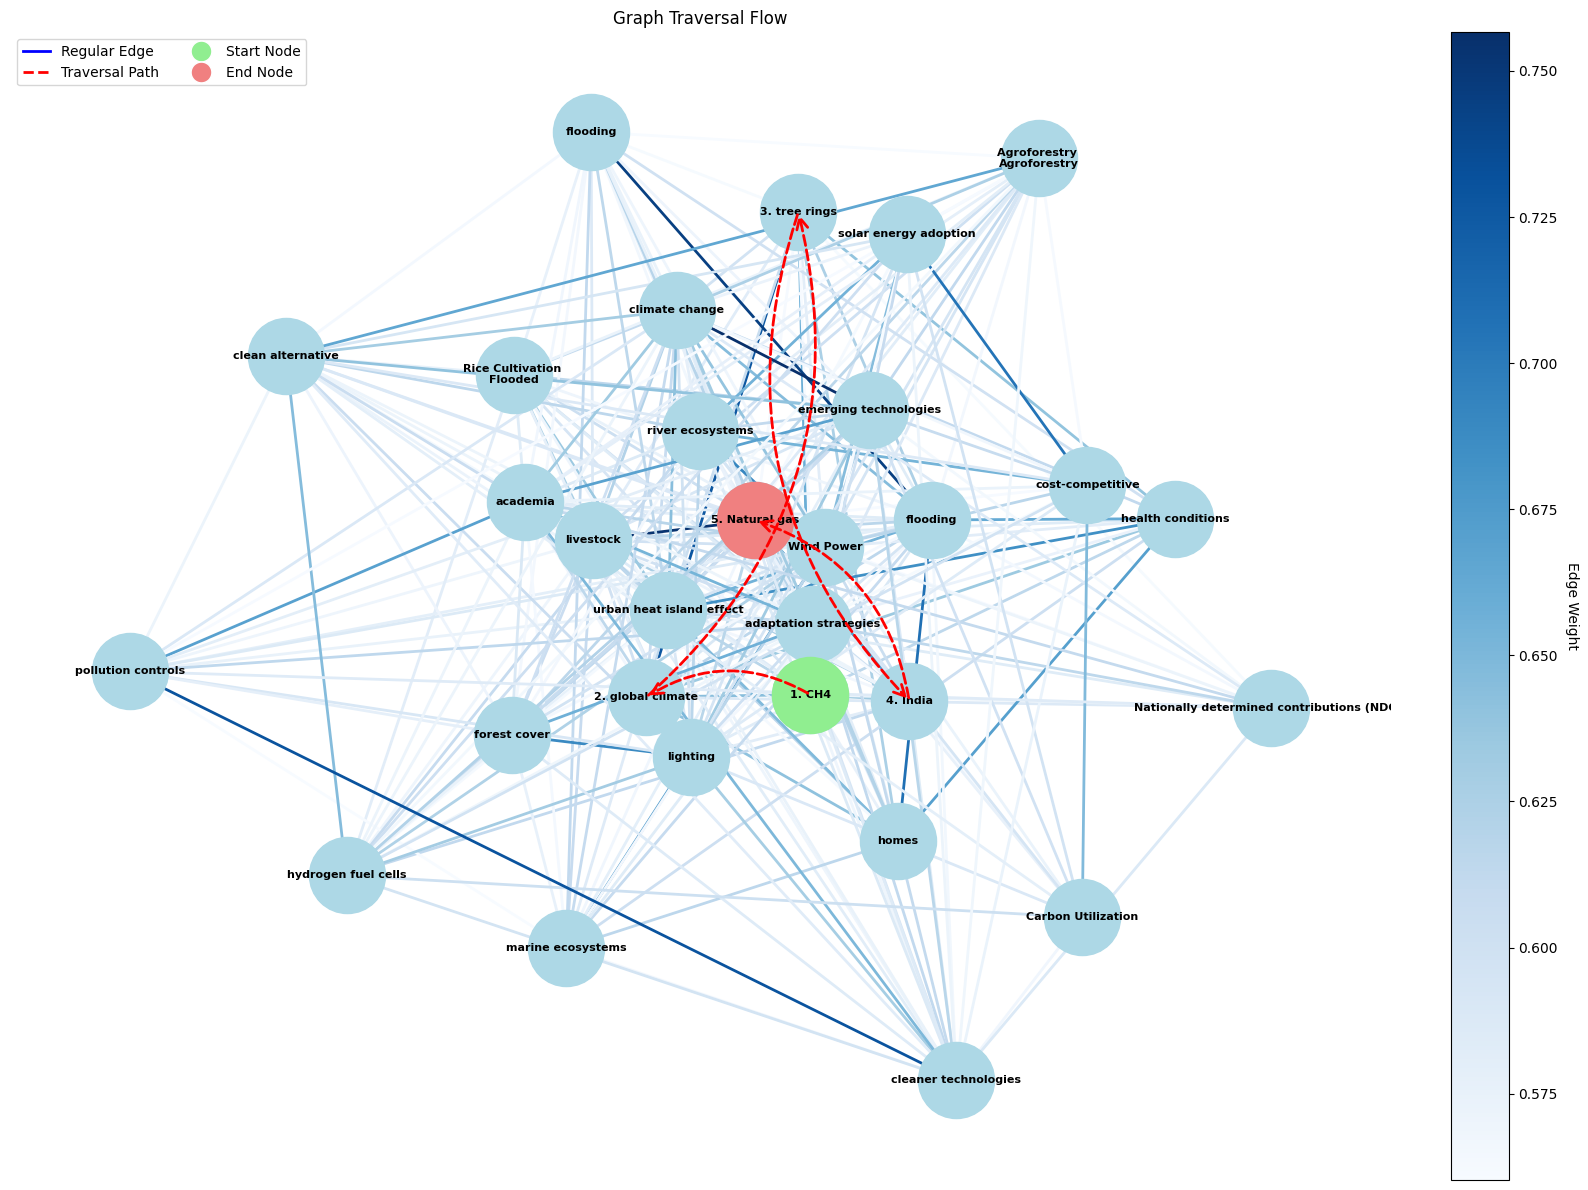

In [10]:
# Define a query related to the document content
query = "what is the main cause of climate change?"

# Submit the query to the GraphRAG pipeline and receive a structured response
response = graph_rag.query(query)

This is the core of the user interaction. The system first embeds the query and searches for semantically similar document chunks. Then, starting from those chunks, it traverses the knowledge graph to find related nodes that provide deeper or supporting information. This combined context is passed to the LLM to generate a coherent and informed answer. If a traversal path exists, it is visualized to help the user understand how the answer was derived—enhancing transparency and trust in the system’s reasoning. The final answer is returned in natural language, completing the RAG loop.